In [ ]:
# perform GO analysis to annotate potential subtypes

In [37]:
library(fgsea)
library(DESeq2)
library(msigdbr)
library(dplyr)
library(clusterProfiler)
library(ggplot2)
library(org.Hs.eg.db)
library(pathview)
library(VennDiagram)
library(Seurat)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loading required package: SummarizedExperiment

Loading required package: M

In [57]:
allMarkers <- readRDS('AllMarkers.rds')
path <- "SeuratOut/integrated-allcomplexity-clustered.rds"
data <- readRDS(path)

In [45]:
head(allMarkers)

gene_name,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene,description
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>
A630095E13Rik,0,1.1317980,0.610,0.245,0,0,A630095E13Rik,NA
D730048I06Rik,0,1.0080420,0.712,0.142,0,0,D730048I06Rik,NA
Svs1,0,0.9861437,0.622,0.274,0,0,Svs1,NA
Ceacam10,0,0.9679818,0.891,0.470,0,0,Ceacam10,CEA cell adhesion molecule 10 [Source:MGI Symbol;Acc:MGI:1347248]
9530003J23Rik,0,0.9478347,0.631,0.254,0,0,9530003J23Rik,RIKEN cDNA 9530003J23 gene [Source:MGI Symbol;Acc:MGI:1924647]
Spink1,0,0.9319424,0.631,0.313,0,0,Spink1,"serine peptidase inhibitor, Kazal type 1 [Source:MGI Symbol;Acc:MGI:106202]"


In [44]:
allMarkers <- allMarkers %>%
        group_by(cluster)

In [117]:
# marker features are only pos/up regulated
# load pathways and perform GSEA
# Or download from MsigDB or http://bioinf.wehi.edu.au/software/MSigDB/
all_gene_sets <-  msigdbr(species = "Mus musculus",category = "H")
all_gene_sets = split(x = all_gene_sets$gene_symbol, f = all_gene_sets$gs_name)
fgseaRes <- list()
for (i in 0:20) {
    subset <- allMarkers[allMarkers$cluster==i,] 
    ranks <- subset$avg_log2FC
    names(ranks) <- subset$gene
    # use fgseaMultiLevel, more robust
    fgsea <- fgsea(pathways=all_gene_sets, ranks)
    fgseaRes[[i+1]] <- fgsea
    fgsea$leadingEdge <- sapply(fgsea$leadingEdge, paste, collapse = ",")
    #write.table(fgsea,file =paste0("GESA/fgsea.cluster",i,".csv"), quote = FALSE, sep = "\t")
}

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“All values in the stats vector are greater than zero and scoreType is "std", maybe you should switch to scoreType = "pos".”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“All values in the stats vector are greater than zero and scoreType is "std", maybe you should switch to scoreType = "pos".”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“All values in the stats vector are greater than zero and scoreType is "std", maybe you should switch to scoreType = "pos".”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“All values in the stats vector are greater than zero and scoreType is "std", maybe you should switch to scoreType = "pos".”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“All values in the stats vector are greater t

In [128]:
# make top 10 table plot
# all non significant... just as reference
for (i in 1:length(fgseaRes)) {
    # get data
    data <- allMarkers[allMarkers$cluster==i-1,] 
    ranks <- subset$avg_log2FC
    names(ranks) <- subset$gene
    fgsea <- fgseaRes[[i]]
    
    # prepare plotting
    topUp <- fgsea %>% 
        top_n(10, wt=-padj)
    topPathways <- bind_rows(topUp) %>% 
        arrange(-ES)
    
    # make the plot
    pdf(paste0("GSEA.cluster",i-1,".pdf"),width=11,height=8,onefile = TRUE)
    p <- plotGseaTable(all_gene_sets[topPathways$pathway], 
              ranks, 
              fgsea, 
              gseaParam = 0.5)
    print(p)
    for (j in 1:10){
        p <- plotEnrichment(all_gene_sets[[fgsea$pathway[j]]], ranks)
        print(p)
    }
    dev.off()
}

Warning message in max(tops):
“no non-missing arguments to max; returning -Inf”
Warning message in min(bottoms):
“no non-missing arguments to min; returning Inf”
Warning message in max(tops):
“no non-missing arguments to max; returning -Inf”
Warning message in min(bottoms):
“no non-missing arguments to min; returning Inf”
Warning message in max(tops):
“no non-missing arguments to max; returning -Inf”
Warning message in min(bottoms):
“no non-missing arguments to min; returning Inf”
Warning message in max(tops):
“no non-missing arguments to max; returning -Inf”
Warning message in min(bottoms):
“no non-missing arguments to min; returning Inf”
Warning message in max(tops):
“no non-missing arguments to max; returning -Inf”
Warning message in min(bottoms):
“no non-missing arguments to min; returning Inf”
Warning message in max(tops):
“no non-missing arguments to max; returning -Inf”
Warning message in min(bottoms):
“no non-missing arguments to min; returning Inf”
Warning message in max(tops)

In [41]:
# compare two epithelial clusters, feel like they could be merged
library(GOsummaries)

In [61]:
genes1 <- allMarkers[allMarkers$cluster==1,'gene']
genes2 <- allMarkers[allMarkers$cluster==11,'gene']
genes <- unique(append(genes1,genes2))

In [64]:
library(Seurat)
expression <- AverageExpression(object=data,assay='RNA',features=genes)

In [78]:
head(expression$RNA[,c(2,12)])

,1,11
Krt14,38.00934,23.455141
Sfn,33.36472,16.886035
Krt17,28.32944,10.852589
Fxyd3,15.18901,18.488421
F3,21.35318,4.400851
Cldn4,36.00028,10.886819


In [90]:
annotations <- data.frame(identity=c('epithelial.1','epithelial.2'))
rownames(annotations) <- c(1,11)

In [91]:
annotations

,identity
,<chr>
1,epithelial.1
11,epithelial.2


In [103]:
# maybe just merge them in the larger umap (no subclustering on basal epithelial cells)
gl = list(List = list(genes1, genes2)) # Two lists per component
gs = gosummaries(gl)
gs_exp = add_expression.gosummaries(gs, exp = expression$RNA[,c(2,12)],annotation=annotations)
plot(gs_exp, fontsize = 8,class='identity',filename = "GSEA/epithelial.pdf")

Warning message:
“Please consider using the new package "gprofiler2". At the moment you are using a deprecated package relying on outdated data.
  More information at https://biit.cs.ut.ee/gprofiler/page/r-new. Feel free to contact us at biit.support@ut.ee for further help.”
No id variables; using all as measure variables

No id variables; using all as measure variables



In [130]:
# compared two annotation
old <- readRDS("seurat_23samples_clustered.rds")
new <- readRDS("SeuratOut/integrated-allcomplexity-labeled.rds")

In [131]:
old

An object of class Seurat 
55322 features across 48246 samples within 3 assays 
Active assay: integrated (3000 features, 3000 variable features)
 2 other assays present: RNA, SCT
 2 dimensional reductions calculated: pca, umap

In [134]:
DefaultAssay(new) <- "integrated"
new

An object of class Seurat 
40261 features across 47804 samples within 3 assays 
Active assay: integrated (2000 features, 1242 variable features)
 2 other assays present: RNA, SCT
 2 dimensional reductions calculated: pca, umap

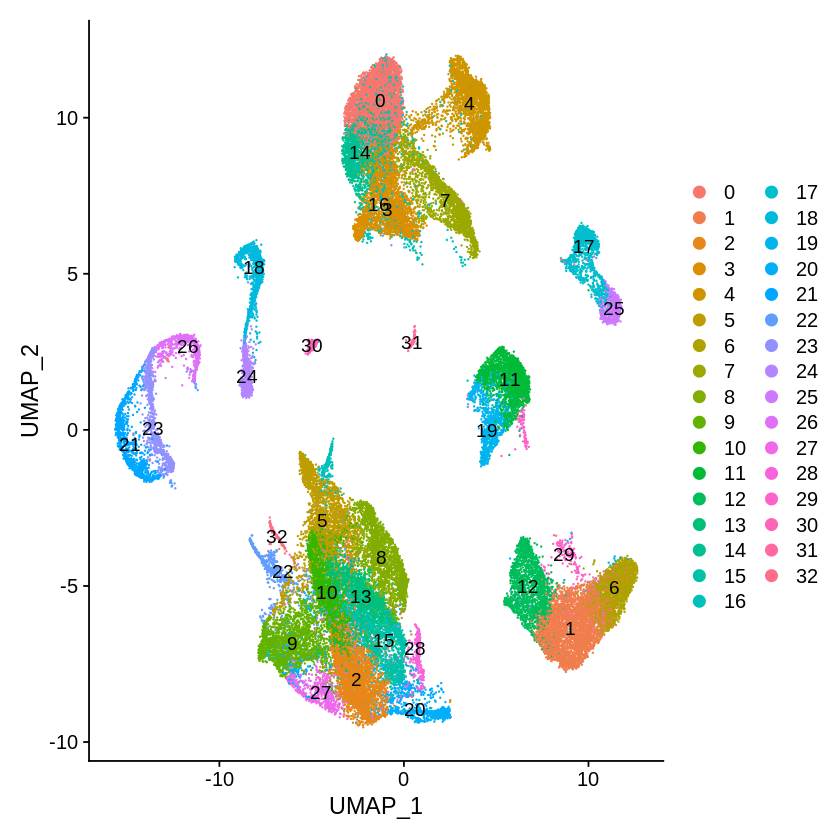

In [137]:
p1 <- DimPlot(old, reduction='umap',label=TRUE)
p1

In [159]:
# see cell overlap
library(VennDiagram)
venn.diagram(x=list("old"=Cells(x=old),"new" = Cells(x=new)),filename="venn.png",
            fill = c(alpha('#21908dff',0.3), alpha('#fde725ff',0.3)),)

[1] 1

In [176]:
palette <- c("Unknown"="#a9a9a9",
             "Secretory.1" = "#344B79",
             "Secretory.2" = "#344B79",       
             "Secretory.3" = "#344B79",
             "Secretory.4" = "#344B79",
             "Secretory.5" = "#344B79",
             "Secretory.6" = "#344B79",
             "Basal Epithelial Cell.1" = "#7c9ee3",
             "Basal Epithelial Cell.2" = "#7c9ee3",
             "mesoderm.1" = "#f03287",
             "mesoderm.2" = "#f03287",
             "mesoderm.3:Fibroblast" = "#f03287",
             "mesoderm.4:Fibroblast(Lum-)" = "#f03287",
             "mesoderm.5:Epithelial" = "#f03287",
             "Endothelial.1" = "#7cd2e3",
             "Endothelial.2" = "#7cd2e3",
             "Macrophage" = "#F06B5F",
             "Vascular smooth muscle cell" = "#4D4031",
             "T cell(Gzma+)" = "#671F18",
             "T cell(Gzma-)" = "#671F18",
             "Schwann cell" = "#8AD293")

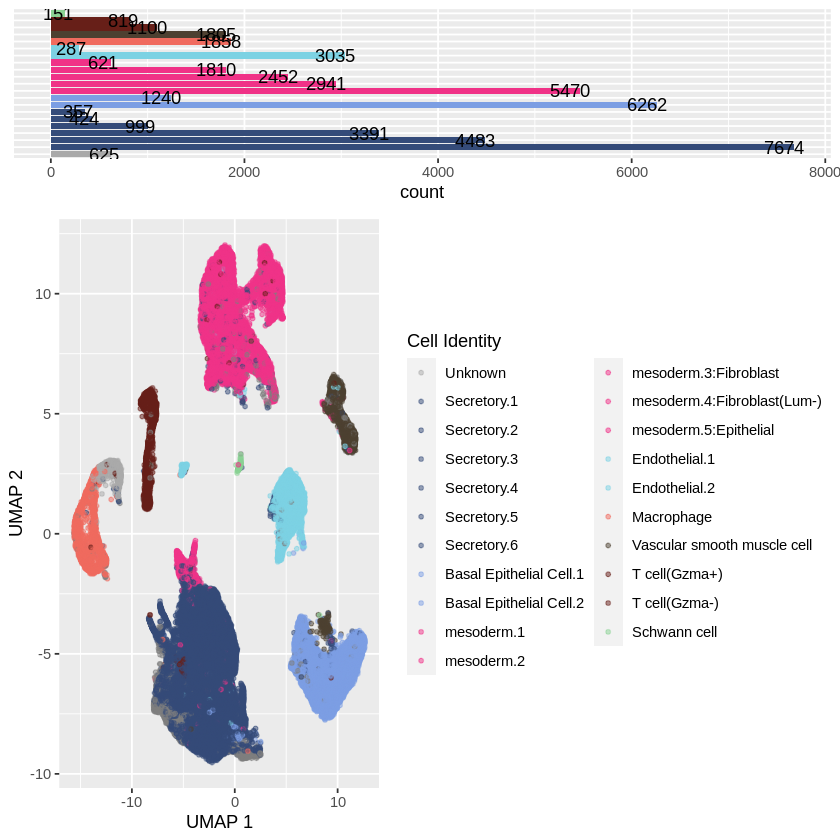

In [215]:
# label old with new labels
p <- Embeddings(object=old,reduction="umap")
labels <- data.frame(table(Idents(new)))
names(labels) <- c("cellType","count")
idents <- Idents(new)
library(gridExtra)
barplot <- ggplot(data=labels,aes(x=cellType,y=count,fill=cellType))+
           geom_bar(stat="identity")+
           scale_fill_manual(values=palette)+
           geom_text(aes(label=count),vjust=0.5,hjust=0.75)+
           theme(axis.title.y=element_blank(),axis.text.y=element_blank(),axis.ticks.y=element_blank())+
           theme(legend.position="none")+
           coord_flip()
umap <- ggplot(data.frame(p),aes(x=UMAP_1, y=UMAP_2, color=idents[rownames(p)]))+
        geom_point(size=1,alpha=0.5)+
        scale_color_manual(name="Cell Identity",values=palette)+
        xlab("UMAP 1")+
        ylab("UMAP 2")
grid.arrange(barplot,umap,ncol=1,nrow=2,heights=c(1,3))